In [1]:
# ==================================
# Experiment 6
# ==================================

# exploring classification boundaries for simple 2d data 
# shows affect of boundary as net architecture changes

In [2]:
# =====================
# Imports
# =====================

from geocert import compute_boundary_batch, compute_l_inf_ball_batch, compute_l2_ball_batch, incremental_geocert
from plnn import PLNN
from _polytope_ import Polytope, from_polytope_dict
import utilities as utils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from convex_adversarial import robust_loss
from sklearn import cluster, datasets, mixture

/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


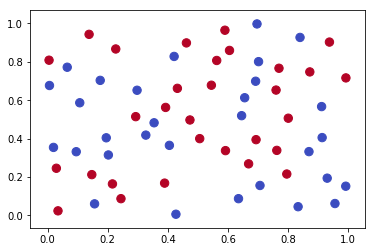

In [3]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for points in R^2.

# ==================================
# Circles / Moons Datasets
# ==================================
n_samples = 1500

# X, y = datasets.make_circles(n_samples=n_samples, factor=.5,
#                                       noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)

# ==================================
# Random Scattered Points
# ==================================

# random points at least 2r apart
xylim = 1.0
m = 60
# np.random.seed(3)
x = [xylim*np.random.uniform(size=(2))]
r = 0.16/3.5
while(len(x) < m):
    p = xylim*np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=70)

===============Initializing Network============
[2, 10, 2, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=2, bias=True)
  (4): ReLU()
  (5): Linear(in_features=2, out_features=2, bias=True)
)
===============Training Network============


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


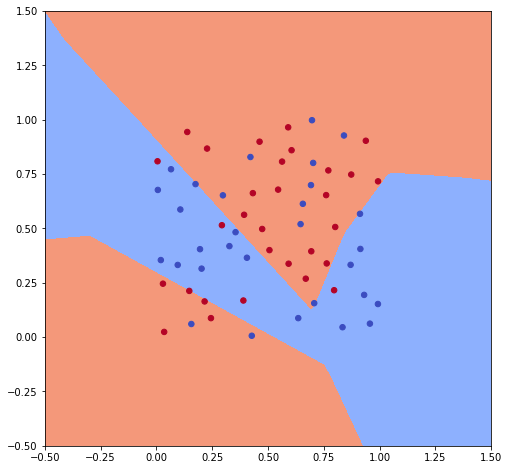

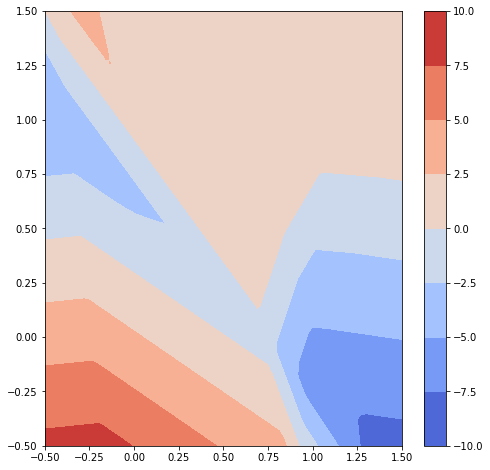

===============Collecting Polytopes============
number of polytopes: 47
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly
an unbounded polytope was plotted imperfectly
an unbounded polytope was plotted imperfectly
an unbounded polytope was plotted imperfectly
an unbounded facet was plotted imperfectly


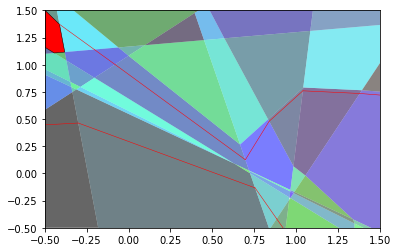

===============Initializing Network============
[2, 10, 3, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=3, bias=True)
  (4): ReLU()
  (5): Linear(in_features=3, out_features=2, bias=True)
)
===============Training Network============


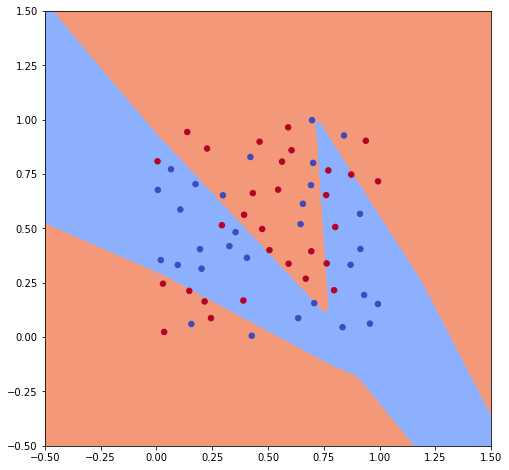

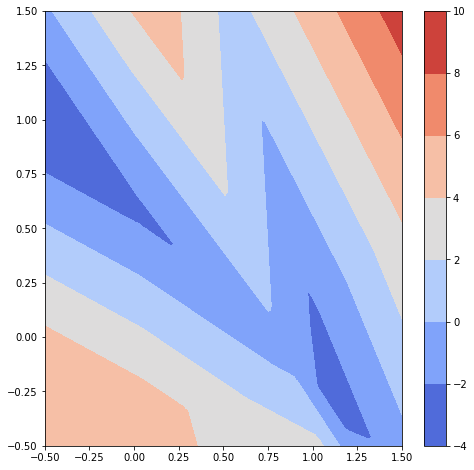

===============Collecting Polytopes============
number of polytopes: 29
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly


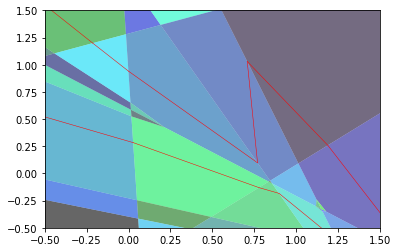

===============Initializing Network============
[2, 10, 5, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=5, bias=True)
  (4): ReLU()
  (5): Linear(in_features=5, out_features=2, bias=True)
)
===============Training Network============


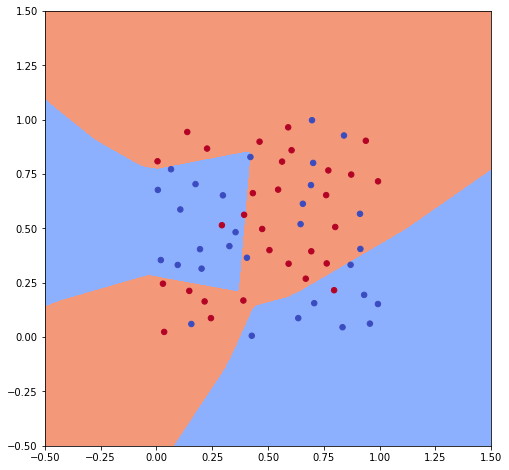

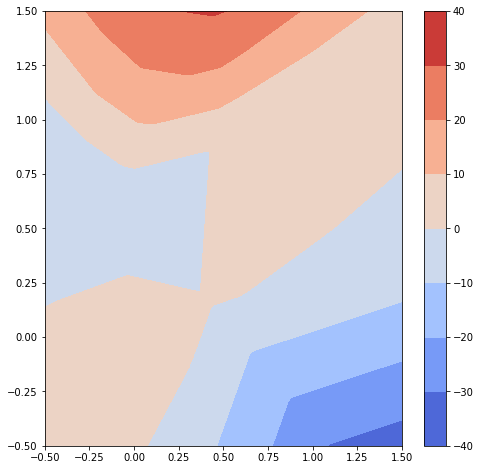

===============Collecting Polytopes============
number of polytopes: 69
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly
an unbounded facet was plotted imperfectly


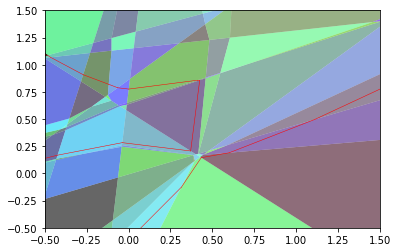

===============Initializing Network============
[2, 10, 7, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=7, bias=True)
  (4): ReLU()
  (5): Linear(in_features=7, out_features=2, bias=True)
)
===============Training Network============


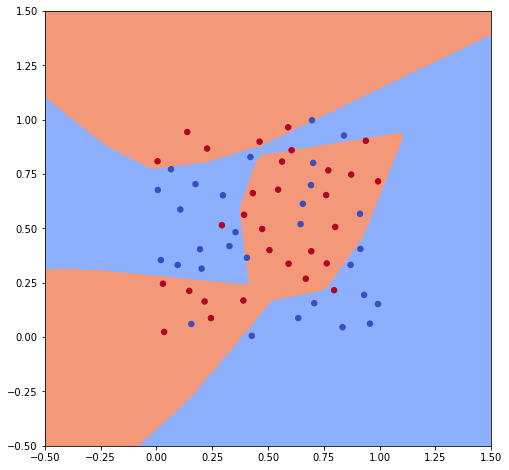

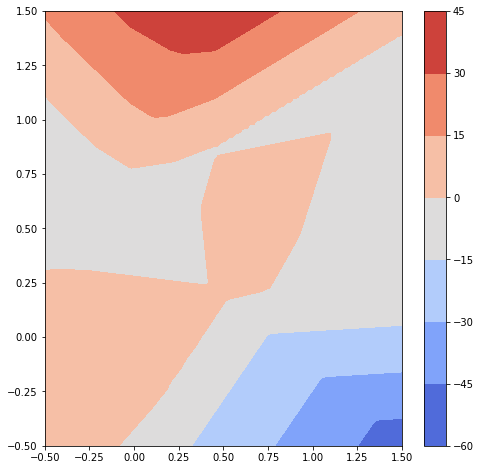

===============Collecting Polytopes============
number of polytopes: 90
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly
an unbounded facet was plotted imperfectly


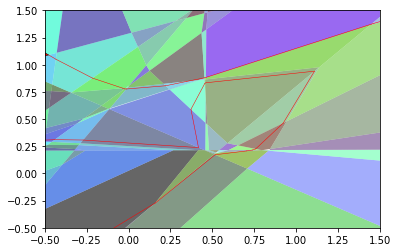

===============Initializing Network============
[2, 10, 8, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=8, bias=True)
  (4): ReLU()
  (5): Linear(in_features=8, out_features=2, bias=True)
)
===============Training Network============


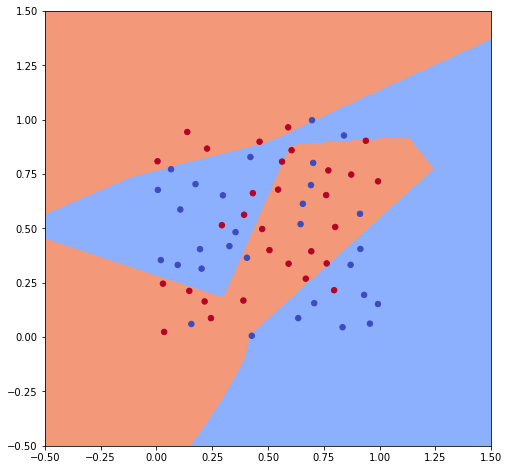

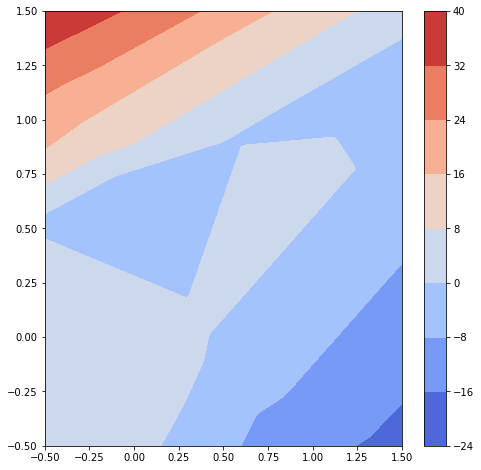

===============Collecting Polytopes============
number of polytopes: 38
===============Finding Classification Boundary Facets============


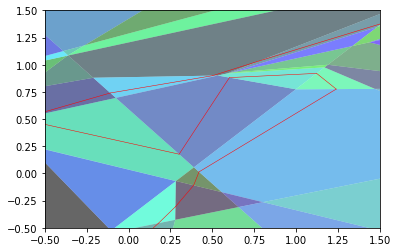

===============Initializing Network============
[2, 10, 10, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=2, bias=True)
)
===============Training Network============


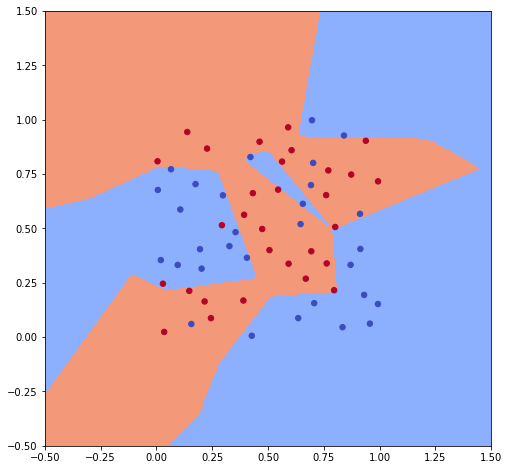

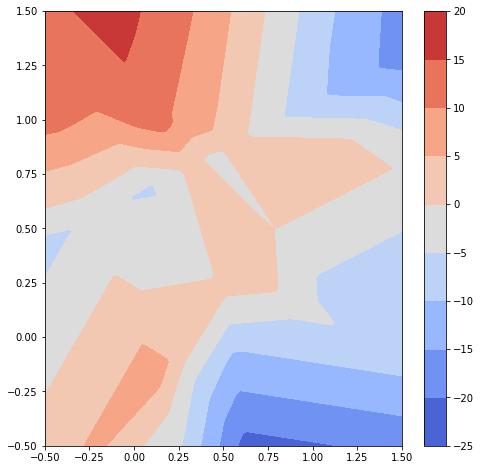

===============Collecting Polytopes============
number of polytopes: 92
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly
an unbounded polytope was plotted imperfectly
an unbounded polytope was plotted imperfectly
an unbounded facet was plotted imperfectly
an unbounded facet was plotted imperfectly


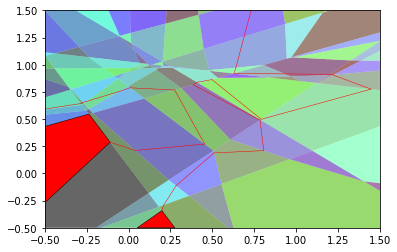

===============Initializing Network============
[2, 10, 12, 2]
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=12, bias=True)
  (4): ReLU()
  (5): Linear(in_features=12, out_features=2, bias=True)
)
===============Training Network============


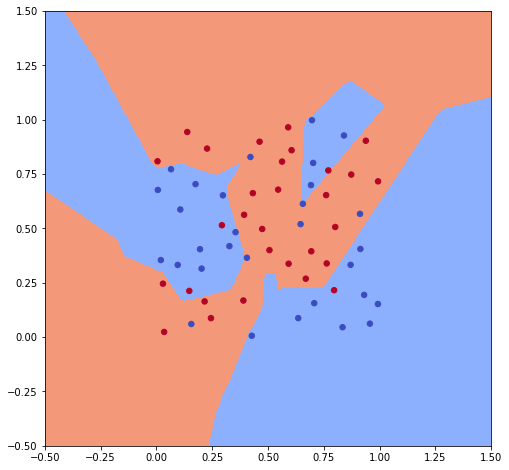

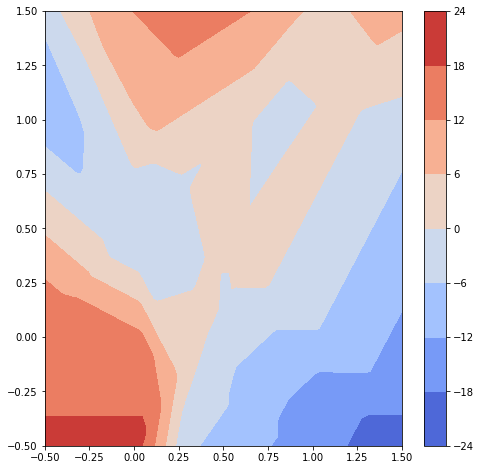

===============Collecting Polytopes============
number of polytopes: 108
===============Finding Classification Boundary Facets============


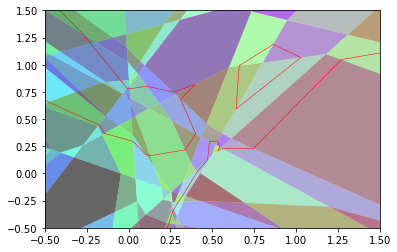

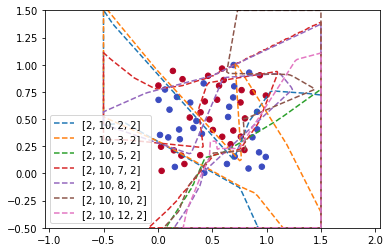

In [4]:

# ==================================
# Architecture Design Loop
# ==================================

sizes_collection = []
for l1 in np.linspace(10, 10, 1):
    for l2 in np.linspace(2, 12, 7):
        layer_sizes = [2, int(l1), int(l2), 2]
        sizes_collection.append(layer_sizes)

decision_boundaries = []
linear_pieces = []
for layer_sizes in sizes_collection:

    # ==================================
    # Initialize Network
    # ==================================

    print('===============Initializing Network============')
    print(layer_sizes)
    network = PLNN(layer_sizes)
    net = network.net


    # ==================================
    # Train Network
    # ==================================

    print('===============Training Network============')
    torch.manual_seed(1)
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(3000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y))
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()

    # ==================================
    # Get classifier boundary
    # ==================================
    xylim = [-.5, 1.5]
    XX, YY = np.meshgrid(np.linspace(xylim[0], xylim[1], 100), np.linspace(xylim[0], xylim[1], 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = network(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

    fig, ax = plt.subplots(figsize=(8,8))
    levels_param = np.linspace(-1000, 1000,3)
    contour_obj = ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=levels_param)
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=30)
    paths = contour_obj.collections[0].get_paths()[0]
    decision_boundary = paths.vertices
    decision_boundaries.append(decision_boundary)
    
    fig, ax = plt.subplots(figsize=(8,8))    
    filename = str(layer_sizes)+'_boundary.svg'
    min_level = min(y0[:,0] - y0[:,1]).detach(); max_level = max(y0[:,0] - y0[:,1]).detach()
    levels_param = np.linspace(min_level,max_level,15)
    contour_obj = ax.contourf(XX,YY,-ZZ, cmap="coolwarm")
    cbar = fig.colorbar(contour_obj)
    plt.savefig('plots/figures/Exp_6/'+filename)
    plt.show()
    
    # ==================================
    # Get Polytopes and Adv. Boundaries
    # ==================================

    print('===============Collecting Polytopes============')
    num_pts = 200

    unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    print('number of polytopes:', len(unique_bin_acts))
    color_dict = utils.get_color_dictionary(unique_bin_acts)
    polytope_list = []


    for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
        polytope_dict = network.compute_polytope_config(relu_configs, True)
        polytope = from_polytope_dict(polytope_dict)
        polytope_list.append(polytope)
        # colors.append(color_dict[unique_act])
    num_colors = max(200, len(polytope_list))
    colors = utils.get_spaced_colors(num_colors)[0:len(polytope_list)]
    x_0 = torch.Tensor([[0.3], [0.5]])
  
    print('===============Finding Classification Boundary Facets============')

    true_label = int(network(x_0).max(1)[1].item())  # what the classifier outputs

    adversarial_facets = []
    for polytope in polytope_list:
        polytope_adv_constraints = network.make_adversarial_constraints(polytope.config,
                                                                        true_label)

        for facet in polytope_adv_constraints:
            adversarial_facets.append(facet)
            
    linear_pieces.append(len(adversarial_facets))
    
    # ------------------------------
    # Plot Polytopes and Adversarial Facets
    # ------------------------------

    plt.clf()
    ax = plt.axes()
    alpha = 0.6
    utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
    
    utils.plot_facets_2d(adversarial_facets, xylim=xylim, ax=ax, color='red', linestyle='solid', linewidth=0.5)
    plt.xlim(xylim[0], xylim[1])
    plt.ylim(xylim[0], xylim[1])
    filename = str(layer_sizes)+'_polytopes.svg'
    plt.savefig('plots/figures/Exp_6/'+filename)
    plt.show()
    
# ==================================
#  Loop END
# ==================================
    
# ==================================
# Plot classifier boundaries
# ==================================

plt.clf()
ax = plt.axes()

for decision_boundary, layer_sizes in zip(decision_boundaries, sizes_collection):
    boundy_x, boundy_y = decision_boundary.T
    ax.plot(boundy_x,boundy_y, linestyle='dashed', label=str(layer_sizes))
    
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=30)
ax.axis("equal")
ax.axis([xylim[0], xylim[1], xylim[0], xylim[1]])
plt.legend()

plt.savefig('plots/figures/Exp_6/boundaries_vs_arch.svg')
plt.show()



In [5]:
# ==================================
# Number of Linear Pieces
# ==================================

print(sizes_collection)
print(linear_pieces)


[[2, 10, 2, 2], [2, 10, 3, 2], [2, 10, 5, 2], [2, 10, 7, 2], [2, 10, 8, 2], [2, 10, 10, 2], [2, 10, 12, 2]]
[14, 11, 18, 30, 14, 31, 42]
